<a href="https://colab.research.google.com/github/vaibhavmishra1/Deep_Learning_with_Keras/blob/master/Neural_style_transfer_in__keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from keras.preprocessing.image import load_img, img_to_array
target_image_path = 'img/2.jpg'
style_reference_image_path = 'img/1.jpg'
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

Using TensorFlow backend.


In [0]:
!mkdir img

In [0]:
import numpy as np
from keras.applications import vgg19
def preprocess_image(image_path):
  img = load_img(image_path, target_size=(img_height, img_width))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = vgg19.preprocess_input(img)
  return img

In [0]:
def deprocess_image(x):
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [5]:
from keras import backend as K
target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, img_height, img_width, 3))
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)
model = vgg19.VGG19(input_tensor=input_tensor,
                                  weights='imagenet',
                                  include_top=False)
print('Model loaded.')

W0812 13:20:51.402499 139626448488320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0812 13:20:51.412884 139626448488320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0812 13:20:51.415471 139626448488320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0812 13:20:51.482823 139626448488320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



80142336/80134624 [==============================] - 1s 0us/step


W0812 13:20:53.470331 139626448488320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0812 13:20:53.471813 139626448488320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



Model loaded.


In [0]:
def content_loss(base, combination):
  return K.sum(K.square(combination - base))

In [0]:
def gram_matrix(x):
  features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
  gram = K.dot(features, K.transpose(features))
  return gram

In [0]:
def style_loss(style, combination):
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = img_height * img_width
  return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [0]:
def total_variation_loss(x):
  a = K.square(
      x[:, :img_height - 1, :img_width - 1, :] -
      x[:, 1:, :img_width - 1, :])
  b = K.square(
      x[:, :img_height - 1, :img_width - 1, :] -
      x[:, :img_height - 1, 1:, :])
  return K.sum(K.pow(a + b, 1.25))

In [0]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
content_layer = 'block5_conv2'
style_layers = ['block1_conv1',
'block2_conv1',
'block3_conv1',
'block4_conv1',
'block5_conv1']
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

In [11]:
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
combination_features)

W0812 13:20:54.427818 139626448488320 variables.py:2429] Variable += will be deprecated. Use variable.assign_add if you want assignment to the variable value or 'x = x + y' if you want a new python Tensor object.


In [0]:
for layer_name in style_layers:
  layer_features = outputs_dict[layer_name]
  style_reference_features = layer_features[1, :, :, :]
  combination_features = layer_features[2, :, :, :]
  sl = style_loss(style_reference_features, combination_features)
  loss += (style_weight / len(style_layers)) * sl

In [0]:
loss += total_variation_weight * total_variation_loss(combination_image)

In [14]:
grads = K.gradients(loss, combination_image)[0]
fetch_loss_and_grads = K.function([combination_image], [loss, grads])
class Evaluator(object):
  def __init__(self):
    self.loss_value = None
    self.grads_values = None
  def loss(self, x):
    assert self.loss_value is None
    x = x.reshape((1, img_height, img_width, 3))
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    self.loss_value = loss_value
    self.grad_values = grad_values
    return self.loss_value
  def grads(self, x):
    assert self.loss_value is not None
    grad_values = np.copy(self.grad_values)
    self.loss_value = None
    self.grad_values = None
    return grad_values
evaluator = Evaluator()

W0812 13:20:55.656903 139626448488320 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Start of iteration 0
Current loss value: 19808164000.0
Iteration 0 completed in 327s
Start of iteration 1
Current loss value: 12214278000.0
Iteration 1 completed in 329s
Start of iteration 2
Current loss value: 8749755000.0
Iteration 2 completed in 328s
Start of iteration 3
Current loss value: 6746507300.0
Iteration 3 completed in 329s
Start of iteration 4
Current loss value: 5309754000.0
Iteration 4 completed in 327s


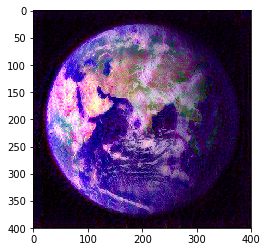

In [17]:
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt

import time
result_prefix = 'my_result'
iterations = 5
x = preprocess_image(target_image_path)

x = x.flatten()
for i in range(iterations):
  print('Start of iteration', i)
  start_time = time.time()
  x, min_val, info = fmin_l_bfgs_b(evaluator.loss,
                                    x,
                                    fprime=evaluator.grads,
                                    maxfun=20)
  print('Current loss value:', min_val)
  img = x.copy().reshape((img_height, img_width, 3))
  img = deprocess_image(img)
  fname = result_prefix + '_at_iteration_%d.png' % i
  plt.imshow(img)
  st="test"+str(i)+".png"
  plt.savefig(st)
  # imsave(fname, img)
  # print('Image saved as', fname)
  end_time = time.time()
  print('Iteration %d completed in %ds' % (i, end_time - start_time))